```bash
conda create --name ani python=3.8
conda install -c conda-forge jupyterlab
pip install open_clip_torch
pip install stable-baselines3
pip install gym[all]
pip install pyglet==1.5.27
pip install tensorboardX
pip install stable-baselines3[extra]
conda install -c anaconda ipywidgets
```

In [1]:
import gym
from stable_baselines3 import DQN
import open_clip
from PIL import Image
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os

In [2]:
def disable_view_window():
        from gym.envs.classic_control import rendering
        org_constructor = rendering.Viewer.__init__

        def constructor(self, *args, **kwargs):
            org_constructor(self, *args, **kwargs)
            self.window.set_visible(visible=False)

        rendering.Viewer.__init__ = constructor

In [3]:
disable_view_window()

In [4]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

In [5]:
class CLIPEnv():
    def __init__(self, env, clip_model, tokenizer, prompt, writer):
        self.env = env
        self.model = clip_model
        self.tokenizer = tokenizer
        self.text_features = self.model.encode_text(self.tokenizer([prompt]))
        self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.metadata = self.env.metadata
        self.clip_rewards = []
        self.actual_rewards = []
        self.writer = writer
        self.n_steps = 0
        self.n_episodes = 0
        
        self.ep_reward = 0
        self.ep_clip_reward = 0

    
    def reset(self):
        self.clip_rewards = []
        self.actual_rewards = []
        return self.env.reset()
    
    def close(self):
        return self.env.close()
    
    def step(self, action):
        next_st, rwd, done, info = self.env.step(action)
        img = self.env.render(mode="rgb_array")
        clip_rwd = self.get_clip_reward(img)
        self.clip_rewards.append(clip_rwd)
        self.actual_rewards.append(rwd)
        self.writer.add_scalar('rewards/env_reward', rwd, self.n_steps)
        self.writer.add_scalar('rewards/clip_reward', clip_rwd, self.n_steps)
        
        self.ep_reward += rwd
        self.ep_clip_reward += clip_rwd
        if done:
            self.writer.add_scalar('episode_rewards/env_reward',  self.ep_reward, self.n_episodes)
            self.writer.add_scalar('episode_rewards/clip_reward', self.ep_clip_reward , self.n_episodes)
            self.n_episodes += 1
            self.ep_reward = 0
            self.ep_clip_reward = 0
        
        self.n_steps += 1

        return next_st, rwd, done, info
    
    def get_clip_reward(self, state):
        image = preprocess(Image.fromarray(np.uint8(state))).unsqueeze(0)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = self.model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            # text_probs = (image_features @ self.text_features.T).softmax(dim=-1)
            sim = (image_features @ self.text_features.T)
        return sim.cpu().detach().numpy()[0][0]

In [6]:
prompt_rewards = {}

In [7]:
!mkdir experiments

mkdir: cannot create directory ‘experiments’: File exists


In [8]:
def experiment_prompt(prompt, agent, env, rewards_storage, n_steps=100):
    obs = env.reset()
    for _ in range(n_steps):
        action, _states = agent.predict(obs)
        obs, rewards, dones, info = env.step(action)
    rewards_storage[prompt] = (env.clip_rewards.copy(), env.actual_rewards.copy())

In [9]:
env = gym.make('LunarLander-v2')

agent = DQN('MlpPolicy', env, verbose=0)
agent.learn(total_timesteps=int(2e5), progress_bar=True)
# Save the agent
agent.save("dqn_lunar")


Output()

In [16]:
EXP_PATH = 'experiments/test/'
if not os.path.exists(EXP_PATH):
    os.mkdir(EXP_PATH)

writer = SummaryWriter(EXP_PATH)

prompt = 'Spaceship is on the landing pad'
env = gym.make('LunarLander-v2')
cl_env = CLIPEnv(env, model, tokenizer, prompt, writer)

agent = DQN.load("dqn_lunar", env=env)

In [17]:
experiment_prompt(prompt, agent, cl_env, prompt_rewards)

In [18]:
cl_env.close()

In [19]:
prompt_rewards

{'Spaceship is on the landing pad': ([0.2454206,
   0.24059787,
   0.24483927,
   0.23660997,
   0.2323823,
   0.23459877,
   0.23713703,
   0.2347091,
   0.23443942,
   0.23858619,
   0.23638532,
   0.23699845,
   0.23481703,
   0.24318741,
   0.25054976,
   0.24597184,
   0.24537823,
   0.2440202,
   0.24452884,
   0.24779414,
   0.24604437,
   0.24363619,
   0.24282838,
   0.25029612,
   0.249405,
   0.2393347,
   0.24343999,
   0.24555102,
   0.25075674,
   0.2486746,
   0.25004837,
   0.24391286,
   0.24474302,
   0.2483539,
   0.24855988,
   0.25214118,
   0.24157108,
   0.24064004,
   0.24593714,
   0.2568885,
   0.24796695,
   0.24356757,
   0.24994701,
   0.25307944,
   0.2488609,
   0.24561024,
   0.24060369,
   0.23945953,
   0.2394996,
   0.24659526,
   0.24710086,
   0.24898516,
   0.24171649,
   0.24798186,
   0.24595012,
   0.23742694,
   0.24360675,
   0.23605263,
   0.24039504,
   0.25157797,
   0.23353204,
   0.24621679,
   0.25005558,
   0.24123779,
   0.24176702,
  

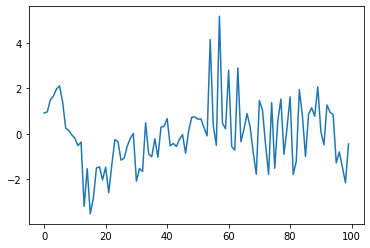

In [20]:
import matplotlib.pyplot as plt
plt.plot(prompt_rewards['Spaceship is on the landing pad'][1])

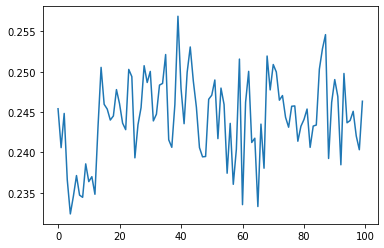

In [21]:
plt.plot(prompt_rewards['Spaceship is on the landing pad'][0])